In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score
import time
from datetime import datetime, timedelta
import os
import sys
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator, TransformerMixin

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns ; sns.set()


from fbprophet import Prophet

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)

DATA_DIR = "../data"

In [2]:

df = pd.read_csv(os.path.join(DATA_DIR, "massey_ordinals_2003-2016.csv"))

In [3]:
df.columns

Index(['season', 'rating_day_num', 'sys_name', 'team', 'orank'], dtype='object')

In [6]:
regular_season_start = {
    2017: "November 11, 2016",
    2016: "November 13, 2015",
    2015: "November 14, 2014",
    2014: "November 8, 2013",
    2013: "November 9, 2012",
    2012: "November 7, 2011",
    2011: "November 8, 2010",
    2010: "November 9, 2009",
    2009: "November 10, 2008",
    2008: "November 5, 2007",
    2007: "November 7, 2006",
    2006: "November 6, 2005",
    2005: "November 10, 2004",
    2004: "November 10, 2003",
    2003: "November 10, 2002"
}


if sys.version_info < (3, 4):
    regular_season_start = {k: datetime.strptime(v, '%B %d, %Y').date() for k, v in regular_season_start.iteritems()}    
else:
    regular_season_start = {k: datetime.strptime(v, '%B %d, %Y').date() for k, v in regular_season_start.items()}


 

-


In [7]:
pipe = Pipeline([
            ('convdays', DayTransformer("season", "rating_day_num", "date"))
        ])

df = pipe.transform(df)


Tournament dates	March 14, 2017 – April 3, 2017

In [8]:
pivoted_massey = df[
    (df["sys_name"].isin(["WOB", "USA"])) &
    (df["team"].isin([1110,1111]))
     ].pivot_table(index=["team", "date"], columns=["sys_name"], values=["orank"],fill_value=0)#.stack(level=0).drop(["sys_name"], axis=1).reset_index()
#pivoted_massey = pivoted_massey.drop(["level_3"], axis=1)
pivoted_massey.head()

orank
sys_name          WOB
team date            
1110 2002-12-17   204
     2002-12-24   204
     2002-12-31   248
     2003-01-06   243
     2003-01-14   248

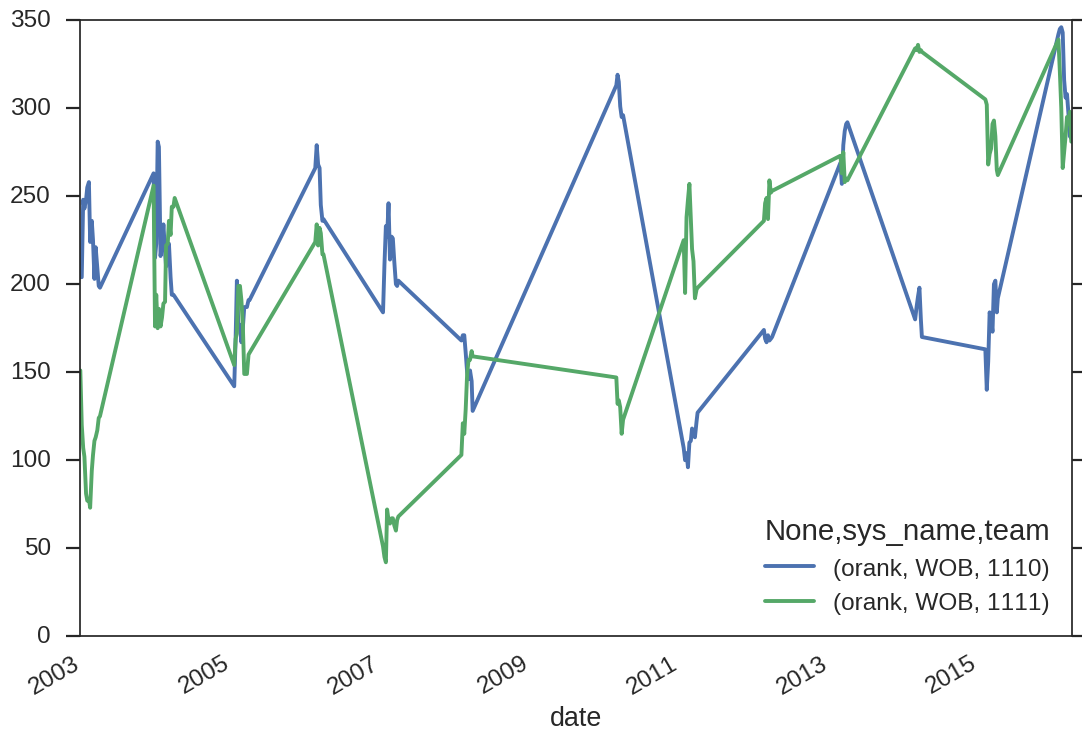

In [9]:
pivoted_massey.unstack(level=0) \
.plot()

In [10]:
pivoted_massey.unstack(level=0).info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 128 entries, 2002-12-17 to 2016-03-25
Data columns (total 2 columns):
(orank, WOB, 1110)    128 non-null int64
(orank, WOB, 1111)    128 non-null int64
dtypes: int64(2)
memory usage: 3.0 KB


In [11]:
df["date"].max()

Timestamp('2016-03-25 00:00:00')

In [12]:
df1 = df[
    (df["sys_name"].isin(["WOB"])) &
    (df["team"].isin([1110]))
     ]

In [13]:
df1["y"] = df1["orank"]#np.log(df1["orank"])
df1["ds"] = df1["date"]
#df['y'] = np.log(df['y'])
df1.head()

/home/algis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/algis/.local/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


season  rating_day_num sys_name  team  orank       date    y         ds
5289     2003              37      WOB  1110    204 2002-12-17  204 2002-12-17
10898    2003              44      WOB  1110    204 2002-12-24  204 2002-12-24
17488    2003              51      WOB  1110    248 2002-12-31  248 2002-12-31
24405    2003              57      WOB  1110    243 2003-01-06  243 2003-01-06
32630    2003              65      WOB  1110    248 2003-01-14  248 2003-01-14

In [14]:
m = Prophet(weekly_seasonality=False)
m.fit(df1)

In [25]:
future = m.make_future_dataframe(periods=20, include_history=True)
future.tail()

ds
143 2016-04-10
144 2016-04-11
145 2016-04-12
146 2016-04-13
147 2016-04-14

In [26]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



ds        yhat  yhat_lower  yhat_upper
143 2016-04-10  249.759978  172.326446  321.718548
144 2016-04-11  248.266124  180.171551  315.523402
145 2016-04-12  246.466525  172.456837  318.797455
146 2016-04-13  244.398839  175.096175  323.797458
147 2016-04-14  242.107077  166.860147  315.230256

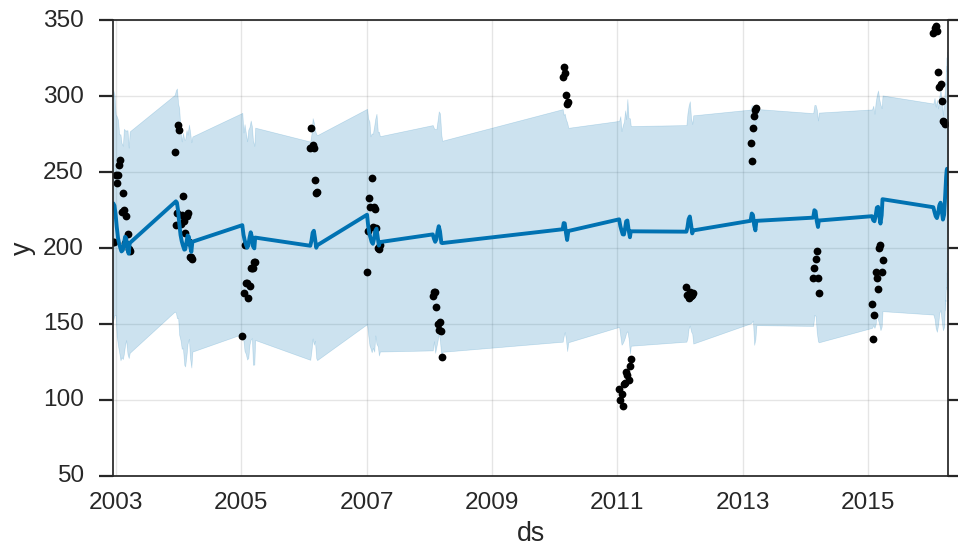

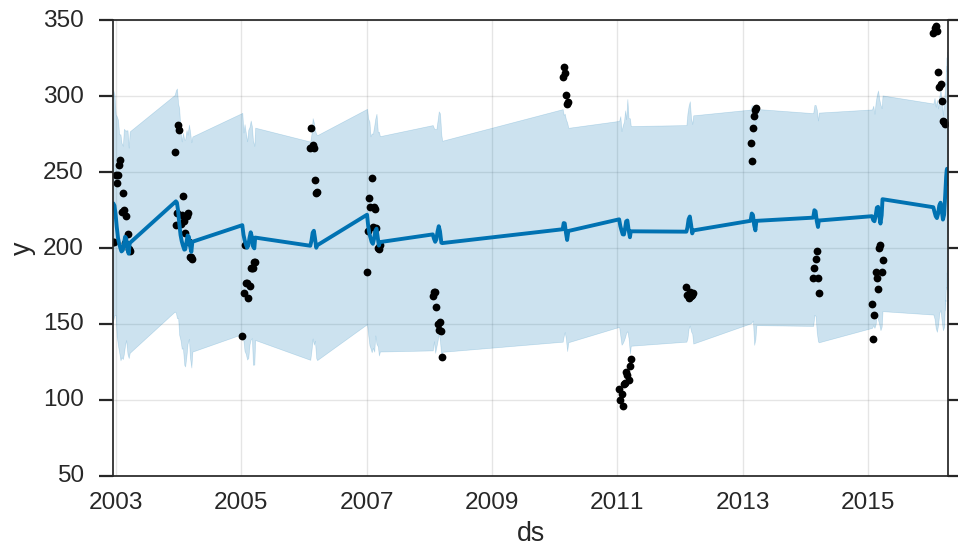

In [27]:
m.plot(forecast)

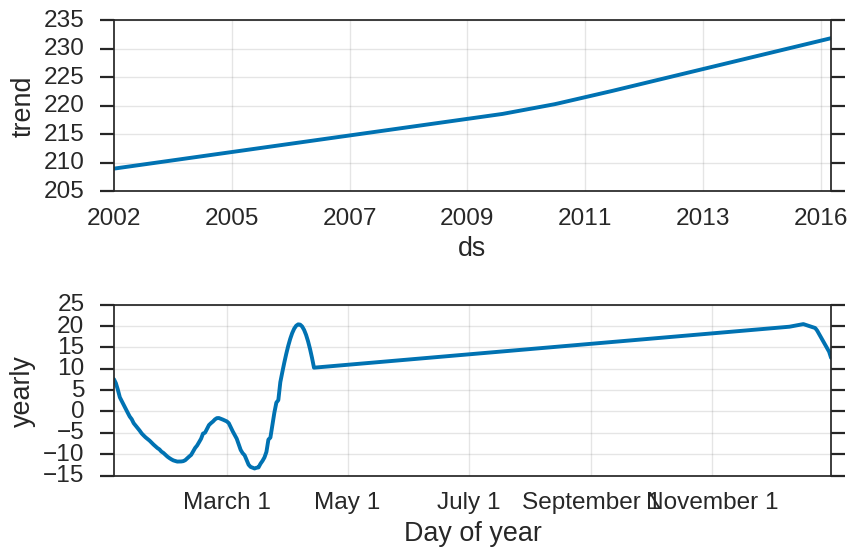

In [28]:
m.plot_components(forecast);

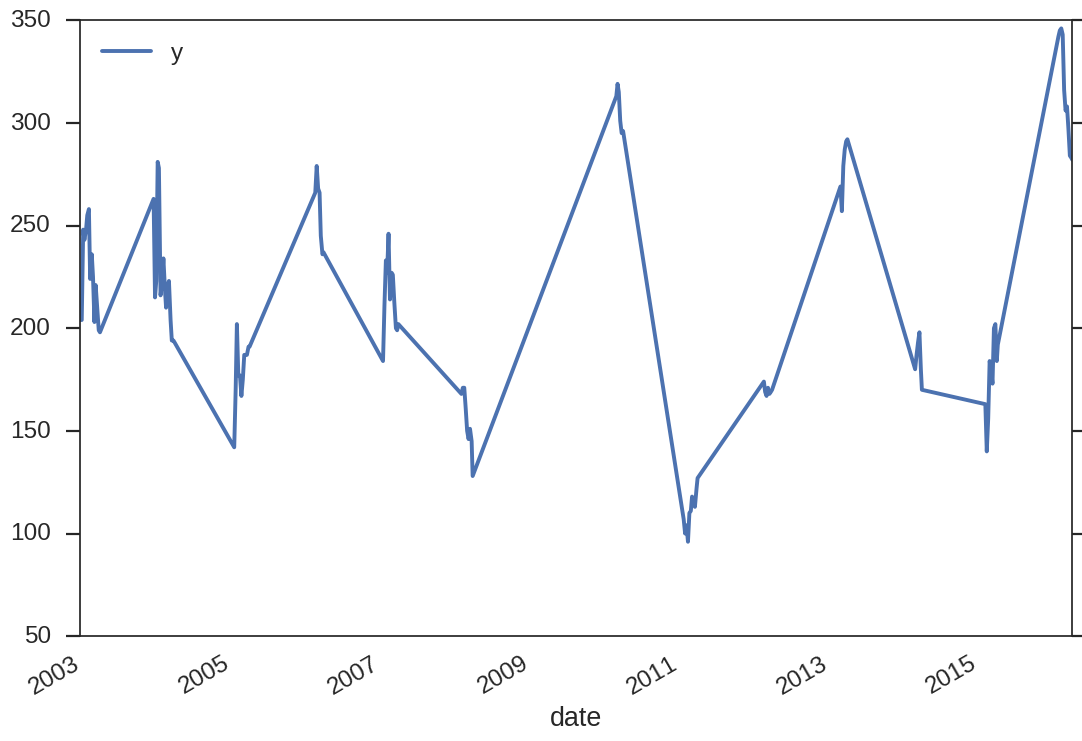

In [29]:
df1.plot(x="date", y="y")